In [49]:
import urllib
import pandas as pd
import os

对主文件进行分析，将数据提取为drug，target，drug-target三个文件

In [50]:
#读取数据
path = 'DrugCentral/drug.target.interaction.tsv.gz'
df=pd.read_table(path,compression='gzip')
df.head()

,DRUG_NAME,STRUCT_ID,TARGET_NAME,TARGET_CLASS,ACCESSION,GENE,SWISSPROT,ACT_VALUE,ACT_UNIT,ACT_TYPE,ACT_COMMENT,ACT_SOURCE,RELATION,MOA,MOA_SOURCE,ACT_SOURCE_URL,MOA_SOURCE_URL,ACTION_TYPE,TDL,ORGANISM
0,levobupivacaine,4,Potassium voltage-gated channel subfamily H me...,Ion channel,Q12809,KCNH2,KCNH2_HUMAN,4.890,NaN,IC50,Inhibition of wild-type human ERG channel expr...,CHEMBL,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
1,levobupivacaine,4,Sodium channel protein type 1 subunit alpha,Ion channel,P35498,SCN1A,SCN1A_HUMAN,5.790,NaN,IC50,NaN,WOMBAT-PK,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
2,levobupivacaine,4,Sodium channel protein type 4 subunit alpha,Ion channel,P35499,SCN4A,SCN4A_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,1.0,CHEMBL,NaN,https://www.ebi.ac.uk/chembl/compound/inspect/...,BLOCKER,Tclin,Homo sapiens
3,levobupivacaine,4,Prostaglandin E2 receptor EP1 subtype,GPCR,P34995,PTGER1,PE2R1_HUMAN,NaN,NaN,NaN,NaN,WOMBAT-PK,NaN,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens
4,levobupivacaine,4,Cytochrome P450 2D6,Enzyme,P10635,CYP2D6,CP2D6_HUMAN,6.707,NaN,IC50,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",DRUG MATRIX,=,NaN,NaN,NaN,NaN,NaN,Tclin,Homo sapiens


In [51]:
# 选取特征,去重
drug_df = df[['STRUCT_ID','DRUG_NAME']]
drug_df= drug_df.drop_duplicates()
drug_df.count()

STRUCT_ID    2587
DRUG_NAME    2587
dtype: int64

In [52]:
#同样的方式选取target特征，去重,并重命名
target_df = df[['ACCESSION','TARGET_NAME','TARGET_CLASS','SWISSPROT','ACTION_TYPE']]
target_df.columns = ['id','TARGET_NAME','TARGET_CLASS','SWISSPROT','ACTION_TYPE']
target_df= target_df.drop_duplicates()
target_df.head()

,id,TARGET_NAME,TARGET_CLASS,SWISSPROT,ACTION_TYPE
0,Q12809,Potassium voltage-gated channel subfamily H me...,Ion channel,KCNH2_HUMAN,NaN
1,P35498,Sodium channel protein type 1 subunit alpha,Ion channel,SCN1A_HUMAN,NaN
2,P35499,Sodium channel protein type 4 subunit alpha,Ion channel,SCN4A_HUMAN,BLOCKER
3,P34995,Prostaglandin E2 receptor EP1 subtype,GPCR,PE2R1_HUMAN,NaN
4,P10635,Cytochrome P450 2D6,Enzyme,CP2D6_HUMAN,NaN


In [53]:
#同样的方式提取合并drug和target的特征，去重，重命名
drug_target_df = df[['STRUCT_ID','ACCESSION','ACT_TYPE','ACT_VALUE','ACT_SOURCE']]
drug_target_df.columns = ['src_vid','dst_vid','ACT_TYPE','ACT_VALUE','ACT_SOURCE']
drug_target_df= drug_target_df.drop_duplicates()
drug_target_df.head()

,src_vid,dst_vid,ACT_TYPE,ACT_VALUE,ACT_SOURCE
0,4,Q12809,IC50,4.890,CHEMBL
1,4,P35498,IC50,5.790,WOMBAT-PK
2,4,P35499,NaN,NaN,WOMBAT-PK
3,4,P34995,NaN,NaN,WOMBAT-PK
4,4,P10635,IC50,6.707,DRUG MATRIX


In [54]:
#将drug_df和target_df，drug_target_df分别保存为csv文件
os.makedirs('processed',exist_ok=True)
drug_df.to_csv('processed/drug_df.csv',index=False)
target_df.to_csv('processed/target_df.csv',index=False)
drug_target_df.to_csv('processed/drug_target_df.csv',index=False)

In [55]:
#使用goupby函数，统计每个target的drug数量
df_count = df.groupby('ACCESSION')['STRUCT_ID'].count()
df_count = df_count.sort_values(ascending=False)
df_count.head()

ACCESSION
Q12809    186
P28223    179
P08913    169
P11229    165
P35462    164
Name: STRUCT_ID, dtype: int64

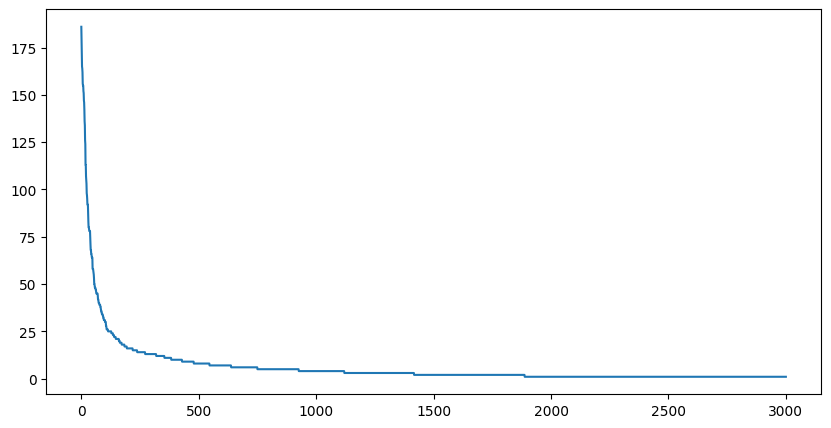

In [56]:
#然后使用图表分析drug数量
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(df_count.values)
plt.show()

将已证实药物文件FDA+EMA+PMDA_Approved读取后，合并到drug.csv中

In [57]:
#读取FDA+EMA+PMDA_Approved文件
path = 'DrugCentral/FDA+EMA+PMDA_Approved.csv'
EMA_df=pd.read_csv(path)
EMA_df.head()

,5376,remdesivir
0,5385,isatuximab
1,4923,nivolumab
2,2994,glucagon
3,5367,trastuzumab deruxtecan
4,5301,baloxavir marboxil


In [58]:
#给EMA_df加一个标题行
EMA_df.columns = ['APPROVED_ID','APPROVED_NAME']
EMA_df.head()

,APPROVED_ID,APPROVED_NAME
0,5385,isatuximab
1,4923,nivolumab
2,2994,glucagon
3,5367,trastuzumab deruxtecan
4,5301,baloxavir marboxil


In [59]:
#将EMA_df和drug_df进行同类项合并
EMA_df1 = pd.merge(EMA_df,drug_df,left_on='APPROVED_NAME',right_on='DRUG_NAME',how='inner')
EMA_df1.head()

,APPROVED_ID,APPROVED_NAME,STRUCT_ID,DRUG_NAME
0,5385,isatuximab,5385,isatuximab
1,4923,nivolumab,4923,nivolumab
2,2994,glucagon,2994,glucagon
3,5367,trastuzumab deruxtecan,5367,trastuzumab deruxtecan
4,5301,baloxavir marboxil,5301,baloxavir marboxil


In [60]:
#给drug_df加一列，标记已证实药物为1，未证实为0
drug_df['APPROVED'] = 0
drug_df.loc[drug_df['STRUCT_ID'].isin(EMA_df1['STRUCT_ID']),'APPROVED'] = 1
drug_df.head()

,STRUCT_ID,DRUG_NAME,APPROVED
0,4,levobupivacaine,0
8,5,(S)-nicardipine,0
9,6,(S)-nitrendipine,0
15,13,levdobutamine,0
16,21,aminopterin,0


In [61]:
#统计drug_df中APPROVED为1的数量
drug_df[drug_df['APPROVED']==1].count()

STRUCT_ID    149
DRUG_NAME    149
APPROVED     149
dtype: int64

将structures.smiles.tsv文件的smiles和inchi数据添加到文件中

In [62]:
#读取structures.smiles.tsv文件
path = 'DrugCentral/structures.smiles.tsv'
smiles_df=pd.read_table(path)
smiles_df.head()

,SMILES,InChI,InChIKey,ID,INN,CAS_RN
0,CNC(=O)C1=C(C=C(C=C1)C2=NN3C(=CN=C3N=C2)CC4=CC...,InChI=1S/C23H17FN6O/c1-25-22(31)18-6-5-16(11-1...,LIOLIMKSCNQPLV-UHFFFAOYSA-N,5392,capmatinib,1029712-80-8
1,CC(C)(COC1=CN2C(=C(C=N2)C#N)C(=C1)C3=CN=C(C=C3...,"InChI=1S/C29H31N7O3/c1-29(2,37)18-39-24-9-25(2...",XIIOFHFUYBLOLW-UHFFFAOYSA-N,5393,selpercatinib,2152628-33-4
2,CCN1C2=CC(=NC=C2C=C(C1=O)C3=CC(=C(C=C3Br)F)NC(...,InChI=1S/C24H21BrFN5O2/c1-3-31-21-12-22(27-2)2...,CEFJVGZHQAGLHS-UHFFFAOYSA-N,5394,ripretinib,1442472-39-0
3,C[C@]12CC[C@H]3[C@H]([C@@H]1C[C@H]([C@@H]2O)[1...,InChI=1S/C18H23FO2/c1-18-7-6-13-12-5-3-11(20)8...,KDLLNMRYZGUVMA-ZYMZXAKXSA-N,5395,fluoroestradiol F 18,94153-53-4
4,C1=CC2=C(C=C1C3=CN=C(C=C3)[18F])NC4=C2C=NC=C4,InChI=1S/C16H10FN3/c17-16-4-2-11(8-19-16)10-1-...,GETAAWDSFUCLBS-SJPDSGJFSA-N,5396,flortaucipir F 18,1522051-90-6


In [63]:
#统计ID的数量
smiles_df['ID'].count()

4099

In [64]:
#提取smiles_df中的特征
smiles_df = smiles_df[['ID','SMILES','InChI','InChIKey']]
smiles_df.head()

,ID,SMILES,InChI,InChIKey
0,5392,CNC(=O)C1=C(C=C(C=C1)C2=NN3C(=CN=C3N=C2)CC4=CC...,InChI=1S/C23H17FN6O/c1-25-22(31)18-6-5-16(11-1...,LIOLIMKSCNQPLV-UHFFFAOYSA-N
1,5393,CC(C)(COC1=CN2C(=C(C=N2)C#N)C(=C1)C3=CN=C(C=C3...,"InChI=1S/C29H31N7O3/c1-29(2,37)18-39-24-9-25(2...",XIIOFHFUYBLOLW-UHFFFAOYSA-N
2,5394,CCN1C2=CC(=NC=C2C=C(C1=O)C3=CC(=C(C=C3Br)F)NC(...,InChI=1S/C24H21BrFN5O2/c1-3-31-21-12-22(27-2)2...,CEFJVGZHQAGLHS-UHFFFAOYSA-N
3,5395,C[C@]12CC[C@H]3[C@H]([C@@H]1C[C@H]([C@@H]2O)[1...,InChI=1S/C18H23FO2/c1-18-7-6-13-12-5-3-11(20)8...,KDLLNMRYZGUVMA-ZYMZXAKXSA-N
4,5396,C1=CC2=C(C=C1C3=CN=C(C=C3)[18F])NC4=C2C=NC=C4,InChI=1S/C16H10FN3/c17-16-4-2-11(8-19-16)10-1-...,GETAAWDSFUCLBS-SJPDSGJFSA-N


In [65]:
#修改smiles_df的列名
smiles_df.columns = ['STRUCT_ID','SMILES','InChI','InChIKey']
smiles_df.head()

,STRUCT_ID,SMILES,InChI,InChIKey
0,5392,CNC(=O)C1=C(C=C(C=C1)C2=NN3C(=CN=C3N=C2)CC4=CC...,InChI=1S/C23H17FN6O/c1-25-22(31)18-6-5-16(11-1...,LIOLIMKSCNQPLV-UHFFFAOYSA-N
1,5393,CC(C)(COC1=CN2C(=C(C=N2)C#N)C(=C1)C3=CN=C(C=C3...,"InChI=1S/C29H31N7O3/c1-29(2,37)18-39-24-9-25(2...",XIIOFHFUYBLOLW-UHFFFAOYSA-N
2,5394,CCN1C2=CC(=NC=C2C=C(C1=O)C3=CC(=C(C=C3Br)F)NC(...,InChI=1S/C24H21BrFN5O2/c1-3-31-21-12-22(27-2)2...,CEFJVGZHQAGLHS-UHFFFAOYSA-N
3,5395,C[C@]12CC[C@H]3[C@H]([C@@H]1C[C@H]([C@@H]2O)[1...,InChI=1S/C18H23FO2/c1-18-7-6-13-12-5-3-11(20)8...,KDLLNMRYZGUVMA-ZYMZXAKXSA-N
4,5396,C1=CC2=C(C=C1C3=CN=C(C=C3)[18F])NC4=C2C=NC=C4,InChI=1S/C16H10FN3/c17-16-4-2-11(8-19-16)10-1-...,GETAAWDSFUCLBS-SJPDSGJFSA-N


In [66]:
#合并drug_df和smiles_df
drug_df = pd.merge(drug_df,smiles_df,on='STRUCT_ID',how='left')
drug_df.head()

,STRUCT_ID,DRUG_NAME,APPROVED,SMILES,InChI,InChIKey
0,4,levobupivacaine,0,CCCCN1CCCC[C@H]1C(=O)NC1=C(C)C=CC=C1C,InChI=1S/C18H28N2O/c1-4-5-12-20-13-7-6-11-16(2...,LEBVLXFERQHONN-INIZCTEOSA-N
1,5,(S)-nicardipine,0,COC(=O)C1=C(C)NC(C)=C([C@H]1C1=CC(=CC=C1)[N+](...,InChI=1S/C26H29N3O6/c1-17-22(25(30)34-4)24(20-...,ZBBHBTPTTSWHBA-DEOSSOPVSA-N
2,6,(S)-nitrendipine,0,CCOC(=O)C1=C(C)NC(C)=C([C@@H]1C1=CC(=CC=C1)[N+...,InChI=1S/C18H20N2O6/c1-5-26-18(22)15-11(3)19-1...,PVHUJELLJLJGLN-INIZCTEOSA-N
3,13,levdobutamine,0,C[C@@H](CCC1=CC=C(O)C=C1)NCCC1=CC=C(O)C(O)=C1,InChI=1S/C18H23NO3/c1-13(2-3-14-4-7-16(20)8-5-...,JRWZLRBJNMZMFE-ZDUSSCGKSA-N
4,21,aminopterin,0,NC1=NC2=NC=C(CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(O...,InChI=1S/C19H20N8O5/c20-15-14-16(27-19(21)26-1...,TVZGACDUOSZQKY-LBPRGKRZSA-N


In [67]:
drug_df.count()

STRUCT_ID    2587
DRUG_NAME    2587
APPROVED     2587
SMILES       2347
InChI        2346
InChIKey     2346
dtype: int64

In [68]:
#改为标准格式
drug_df.columns = ['id','DRUG_NAME','APPROVED','SMILES','InChI','InChIKey']
drug_df=drug_df[['id','DRUG_NAME','SMILES','InChI','InChIKey','APPROVED']]
drug_df=drug_df.drop_duplicates()
drug_df.head()

,id,DRUG_NAME,SMILES,InChI,InChIKey,APPROVED
0,4,levobupivacaine,CCCCN1CCCC[C@H]1C(=O)NC1=C(C)C=CC=C1C,InChI=1S/C18H28N2O/c1-4-5-12-20-13-7-6-11-16(2...,LEBVLXFERQHONN-INIZCTEOSA-N,0
1,5,(S)-nicardipine,COC(=O)C1=C(C)NC(C)=C([C@H]1C1=CC(=CC=C1)[N+](...,InChI=1S/C26H29N3O6/c1-17-22(25(30)34-4)24(20-...,ZBBHBTPTTSWHBA-DEOSSOPVSA-N,0
2,6,(S)-nitrendipine,CCOC(=O)C1=C(C)NC(C)=C([C@@H]1C1=CC(=CC=C1)[N+...,InChI=1S/C18H20N2O6/c1-5-26-18(22)15-11(3)19-1...,PVHUJELLJLJGLN-INIZCTEOSA-N,0
3,13,levdobutamine,C[C@@H](CCC1=CC=C(O)C=C1)NCCC1=CC=C(O)C(O)=C1,InChI=1S/C18H23NO3/c1-13(2-3-14-4-7-16(20)8-5-...,JRWZLRBJNMZMFE-ZDUSSCGKSA-N,0
4,21,aminopterin,NC1=NC2=NC=C(CNC3=CC=C(C=C3)C(=O)N[C@@H](CCC(O...,InChI=1S/C19H20N8O5/c20-15-14-16(27-19(21)26-1...,TVZGACDUOSZQKY-LBPRGKRZSA-N,0


In [69]:
#保存drug_df
drug_df.to_csv('processed/drug_df.csv',index=False)